In [1]:
import warnings
import numpy as np
from tensorflow.keras.layers import Input, Dense, Lambda, Concatenate, Conv2D, Conv2DTranspose, Flatten, Reshape, Add
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers.legacy import Adam
import h5py
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
import cv2
warnings.filterwarnings('ignore')

2023-07-25 08:57:07.683492: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-25 08:57:08.135791: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# DATA PROCESSING

In [2]:
import h5py
with h5py.File("/home/danielaguirre/Documents/university/masteringml/MML-project/data/processed_data.h5", "r") as f:
    imgs_train, labels_train = np.array(f["X_train"]), np.array(f["y_train"])
    imgs_test, labels_test = np.array(f["X_test"]), np.array(f["y_test"])

imgs_train2 = []
imgs_test2 = []
for img in imgs_train:
    new_img = cv2.resize(img, (128,128))
    new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
    imgs_train2.append(new_img)
for img in imgs_test:
    new_img = cv2.resize(img, (128,128))
    new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
    imgs_test2.append(new_img)
imgs_train = np.array(imgs_train2)[:, :, :, np.newaxis]
imgs_test = np.array(imgs_test2)[:, :, :, np.newaxis]
imgs_train2 = (imgs_train-127.5)/127.5
imgs_test2 = (imgs_test-127.5)/127.5

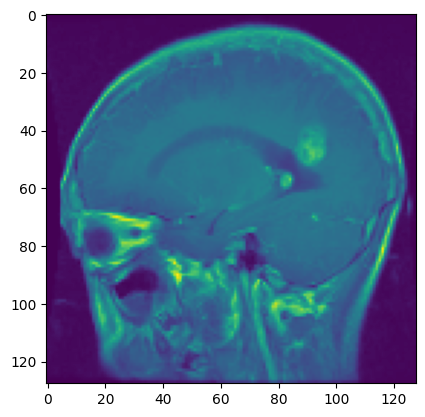

In [3]:
plt.imshow(imgs_train2[0])

# CVAE

In [4]:
batch_size = 128 # batch size
latent_dim = 256 # latent space size
optim = Adam(lr=0.0001)
shape_img = imgs_train.shape[1:]
n_cat = labels_train.shape[1]
n_epoch = 200

### Encoder

In [5]:
enc_input_image = Input(shape=(shape_img), name="input_image")
enc_input_label = Input(shape=(n_cat), name="input_label")

# convolutionals block
enc_conv = Conv2D(filters=64, kernel_size=3, padding="same", activation="relu")(enc_input_image) # 128x128x64
enc_conv = Conv2D(filters=64, kernel_size=3, padding="same", activation="relu", strides=2)(enc_conv) # 64x64x64

enc_conv = Conv2D(filters=128, kernel_size=3, padding="same", activation="relu")(enc_conv) # 64x64x128
enc_conv = Conv2D(filters=128, kernel_size=3, padding="same", activation="relu", strides=2)(enc_conv) # 32x32x128

enc_conv = Conv2D(filters=256, kernel_size=3, padding="same", activation="relu")(enc_conv) # 32x32x256
enc_conv = Conv2D(filters=256, kernel_size=3, padding="same", activation="relu")(enc_conv) # 32x32x256
enc_conv = Conv2D(filters=256, kernel_size=3, padding="same", activation="relu")(enc_conv) # 32x32x256
enc_conv = Conv2D(filters=256, kernel_size=3, padding="same", activation="relu", strides=2)(enc_conv) # 16x16x256

enc_conv = Conv2D(filters=512, kernel_size=3, padding="same", activation="relu")(enc_conv) # 16x16x512
enc_conv = Conv2D(filters=512, kernel_size=3, padding="same", activation="relu")(enc_conv) # 16x16x512
enc_conv = Conv2D(filters=512, kernel_size=3, padding="same", activation="relu")(enc_conv) # 16x16x512
enc_conv = Conv2D(filters=512, kernel_size=3, padding="same", activation="relu", strides=2)(enc_conv) # 8x8x512

enc_conv = Conv2D(filters=512, kernel_size=3, padding="same", activation="relu")(enc_conv) # 8x8x512
enc_conv = Conv2D(filters=512, kernel_size=3, padding="same", activation="relu")(enc_conv) # 8x8x512
enc_conv = Conv2D(filters=512, kernel_size=3, padding="same", activation="relu")(enc_conv) # 8x8x512
enc_conv = Conv2D(filters=512, kernel_size=3, padding="same", activation="relu", strides=2)(enc_conv) # 4x4x512

flattened = Flatten()(enc_conv)
enc_concat = Concatenate()([flattened, enc_input_label])

enc_hidden = Dense(4096)(enc_concat)
enc_hidden = Dense(4096)(enc_hidden)
enc_hidden = Dense(1000)(enc_hidden)
enc_concat = Concatenate()([flattened, enc_input_label])

mu = Dense(latent_dim, activation='linear', name="mu")(enc_hidden)
l_sigma = Dense(latent_dim, activation='linear', name="l_sigma")(enc_hidden)
def sample_z(args):
    mu, l_sigma = args
    eps = K.random_normal(shape=(latent_dim, ), mean=0., stddev=1.) # shape antes => (batch_size, latent_dim)
    return mu + K.exp(l_sigma / 2) * eps
z = Lambda(sample_z, output_shape = (latent_dim, ), name="latent_vector")([mu, l_sigma]) # output encoder

### Decoder

In [6]:
dec_concat = Concatenate(name="decoder_concat")([z, enc_input_label])

decoder_hidden = Dense(512, activation="relu", name="hidden_layer")(dec_concat)
decoder_hidden = Dense(1048, activation="relu", name="hidden_layer2")(decoder_hidden)
decoder_hidden = Dense(16*16*32, activation="relu", name="hidden_layer3")(decoder_hidden)
reshaped = Reshape(target_shape=(16,16,32))(decoder_hidden)

# convolutionals block
dec_conv1 = Conv2DTranspose(filters=256, kernel_size=3, activation="relu", padding='same')(reshaped)
dec_skipped = Add()([dec_conv1, enc_conv4])
dec_conv2 = Conv2DTranspose(filters=128, kernel_size=3, activation="relu", padding='same')(dec_skipped)
dec_conv3 = Conv2DTranspose(filters=64, kernel_size=3, activation="relu", strides=2, padding='same')(dec_conv2)
dec_skipped = Add()([dec_conv3, enc_conv2])
dec_conv4 = Conv2DTranspose(filters=32, kernel_size=3, activation="relu", strides=2, padding='same')(dec_skipped)

dec_output_img = Conv2DTranspose(filters=32, kernel_size=3, activation="relu", strides=2, padding='same')(dec_conv4)
dec_output_img = Conv2DTranspose(filters=1, kernel_size=3, padding="same", activation="sigmoid")(dec_output_img)
dec_output_img = Flatten()(dec_output_img)

### Conditional Variational autoencoder

In [7]:
CVAE = Model(inputs=[enc_input_image, enc_input_label], outputs=dec_output_img)

In [8]:
CVAE.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   320         ['input_image[0][0]']            
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 16, 16, 128)  73856       ['conv2d_1[0][0]']           

## Entrenamiento

In [9]:
def vae_loss(y_true, y_pred):
    recon = recon_loss(y_true, y_pred)
    kl = KL_loss(y_true, y_pred)
    return recon + kl

def KL_loss(y_true, y_pred): # it doesnt use y_true and y_pred but the parameters are necessary for compiling
     # importante se usan las capas de mu y sigma del encoder
    return(0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

In [10]:
CVAE.compile(optimizer=optim, loss=vae_loss, metrics=[KL_loss, recon_loss])

In [11]:
y_train = imgs_train.reshape(imgs_train.shape[0], -1)
y_test = imgs_test.reshape(imgs_test.shape[0], -1)
print(y_train.shape)

(2937, 16384)


In [12]:
checkpoint_filepath = 'model_checkpoints/checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
                                filepath=checkpoint_filepath,
                                save_weights_only=True,
                                monitor='val_loss',
                                mode='min',
                                save_best_only=True)
early_stop = EarlyStopping(patience = 50)

cvae_hist = CVAE.fit([imgs_train2, labels_train], y_train/255, verbose = 1, batch_size=batch_size, epochs=n_epoch,
                      validation_data = ([imgs_test2, labels_test], y_test/255))

Train on 2937 samples, validate on 327 samples


2023-07-25 00:42:54.418005: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-25 00:42:54.431226: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-25 00:42:54.431351: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/200


2023-07-25 00:42:57.133864: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-25 00:42:57.485067: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-25 00:42:57.485465: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-25 00:42:57.485477: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] Couldn't get ptxas version : FAILED_PRECONDITION: Couldn't get ptxas/nvlink version string: INTERNAL: Couldn't invoke ptxas --version
2023-07-25 00:42:57.485875: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-25 00:42:57.485908: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:317] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This mes

2937/2937 [==============================] - ETA: 0s - loss: 11423.6258 - KL_loss: 2.5310 - recon_loss: 11421.0947

2023-07-25 00:43:01.436319: W tensorflow/c/c_api.cc:300] Operation '{name:'loss/mul' id:644 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/flatten_1_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2937/2937 [==============================] - 5s 2ms/sample - loss: 11423.6258 - KL_loss: 2.5310 - recon_loss: 11421.0947 - val_loss: 11325.2594 - val_KL_loss: 0.1286 - val_recon_loss: 11325.1309
Epoch 2/200
2937/2937 [==============================] - 1s 358us/sample - loss: 11243.0857 - KL_loss: 1.9460 - recon_loss: 11241.1396 - val_loss: 10969.5091 - val_KL_loss: 36.2597 - val_recon_loss: 10933.2490
Epoch 3/200
2937/2937 [==============================] - 1s 365us/sample - loss: 8869.3511 - KL_loss: 151.8264 - recon_loss: 8717.5264 - val_loss: 7439.5757 - val_KL_loss: 28.4686 - val_recon_loss: 7411.1069
Epoch 4/200
2937/2937 [==============================] - 1s 349us/sample - loss: 7332.9329 - KL_loss: 35.3196 - recon_loss: 7297.6133 - val_loss: 7058.3893 - val_KL_loss: 38.3039 - val_recon_loss: 7020.0854
Epoch 5/200
2937/2937 [==============================] - 1s 346us/sample - loss: 7065.2221 - KL_loss: 28.0326 - recon_loss: 7037.1890 - val_loss: 6925.1043 - val_KL_loss: 27.2422 -

2937/2937 [==============================] - 1s 363us/sample - loss: 6014.6094 - KL_loss: 7.5534 - recon_loss: 6007.0557 - val_loss: 5961.8900 - val_KL_loss: 5.6862 - val_recon_loss: 5956.2036
Epoch 41/200
2937/2937 [==============================] - 1s 367us/sample - loss: 6010.9449 - KL_loss: 7.4432 - recon_loss: 6003.5015 - val_loss: 5950.0977 - val_KL_loss: 6.3136 - val_recon_loss: 5943.7842
Epoch 42/200
2937/2937 [==============================] - 1s 358us/sample - loss: 5999.2457 - KL_loss: 6.1960 - recon_loss: 5993.0488 - val_loss: 5944.6948 - val_KL_loss: 5.8304 - val_recon_loss: 5938.8647
Epoch 43/200
2937/2937 [==============================] - 1s 359us/sample - loss: 5999.6471 - KL_loss: 6.6177 - recon_loss: 5993.0288 - val_loss: 5942.7891 - val_KL_loss: 6.2025 - val_recon_loss: 5936.5864
Epoch 44/200
2937/2937 [==============================] - 1s 352us/sample - loss: 5994.0760 - KL_loss: 7.0857 - recon_loss: 5986.9902 - val_loss: 5945.8103 - val_KL_loss: 7.4931 - val_recon

Epoch 80/200
2937/2937 [==============================] - 1s 355us/sample - loss: 5907.5371 - KL_loss: 5.7232 - recon_loss: 5901.8140 - val_loss: 5863.2109 - val_KL_loss: 7.1914 - val_recon_loss: 5856.0200
Epoch 81/200
2937/2937 [==============================] - 1s 365us/sample - loss: 5901.6259 - KL_loss: 6.0736 - recon_loss: 5895.5527 - val_loss: 5850.8923 - val_KL_loss: 6.3380 - val_recon_loss: 5844.5542
Epoch 82/200
2937/2937 [==============================] - 1s 363us/sample - loss: 5903.1060 - KL_loss: 6.1467 - recon_loss: 5896.9595 - val_loss: 5852.4354 - val_KL_loss: 7.1040 - val_recon_loss: 5845.3315
Epoch 83/200
2937/2937 [==============================] - 1s 355us/sample - loss: 5901.6723 - KL_loss: 5.8671 - recon_loss: 5895.8062 - val_loss: 5851.9849 - val_KL_loss: 6.8246 - val_recon_loss: 5845.1602
Epoch 84/200
2937/2937 [==============================] - 1s 360us/sample - loss: 5905.7625 - KL_loss: 7.2273 - recon_loss: 5898.5352 - val_loss: 5847.3090 - val_KL_loss: 6.262

Epoch 120/200
2937/2937 [==============================] - 1s 355us/sample - loss: 5866.9641 - KL_loss: 5.5633 - recon_loss: 5861.4014 - val_loss: 5814.1546 - val_KL_loss: 5.3064 - val_recon_loss: 5808.8481
Epoch 121/200
2937/2937 [==============================] - 1s 360us/sample - loss: 5867.0284 - KL_loss: 5.5601 - recon_loss: 5861.4688 - val_loss: 5827.5398 - val_KL_loss: 5.5487 - val_recon_loss: 5821.9912
Epoch 122/200
2937/2937 [==============================] - 1s 360us/sample - loss: 5868.6929 - KL_loss: 5.9314 - recon_loss: 5862.7612 - val_loss: 5813.9207 - val_KL_loss: 4.9325 - val_recon_loss: 5808.9888
Epoch 123/200
2937/2937 [==============================] - 1s 363us/sample - loss: 5871.9019 - KL_loss: 6.1675 - recon_loss: 5865.7344 - val_loss: 5815.9156 - val_KL_loss: 5.0150 - val_recon_loss: 5810.9004
Epoch 124/200
2937/2937 [==============================] - 1s 354us/sample - loss: 5867.5023 - KL_loss: 6.2369 - recon_loss: 5861.2651 - val_loss: 5815.4846 - val_KL_loss: 

2937/2937 [==============================] - 1s 358us/sample - loss: 5849.6535 - KL_loss: 5.5387 - recon_loss: 5844.1143 - val_loss: 5794.5431 - val_KL_loss: 4.8343 - val_recon_loss: 5789.7085
Epoch 160/200
2937/2937 [==============================] - 1s 365us/sample - loss: 5849.0801 - KL_loss: 4.3718 - recon_loss: 5844.7080 - val_loss: 5795.1159 - val_KL_loss: 5.5731 - val_recon_loss: 5789.5435
Epoch 161/200
2937/2937 [==============================] - 1s 353us/sample - loss: 5852.5148 - KL_loss: 4.9334 - recon_loss: 5847.5820 - val_loss: 5803.7399 - val_KL_loss: 5.0272 - val_recon_loss: 5798.7129
Epoch 162/200
2937/2937 [==============================] - 1s 369us/sample - loss: 5848.2198 - KL_loss: 4.8852 - recon_loss: 5843.3340 - val_loss: 5797.4273 - val_KL_loss: 3.8889 - val_recon_loss: 5793.5381
Epoch 163/200
2937/2937 [==============================] - 1s 355us/sample - loss: 5848.4590 - KL_loss: 4.6412 - recon_loss: 5843.8174 - val_loss: 5796.5809 - val_KL_loss: 4.2209 - val_r

Epoch 199/200
2937/2937 [==============================] - 1s 363us/sample - loss: 5839.3806 - KL_loss: 4.6718 - recon_loss: 5834.7090 - val_loss: 5784.5008 - val_KL_loss: 3.9186 - val_recon_loss: 5780.5820
Epoch 200/200
2937/2937 [==============================] - 1s 369us/sample - loss: 5840.9631 - KL_loss: 4.6796 - recon_loss: 5836.2832 - val_loss: 5787.8805 - val_KL_loss: 5.4198 - val_recon_loss: 5782.4604


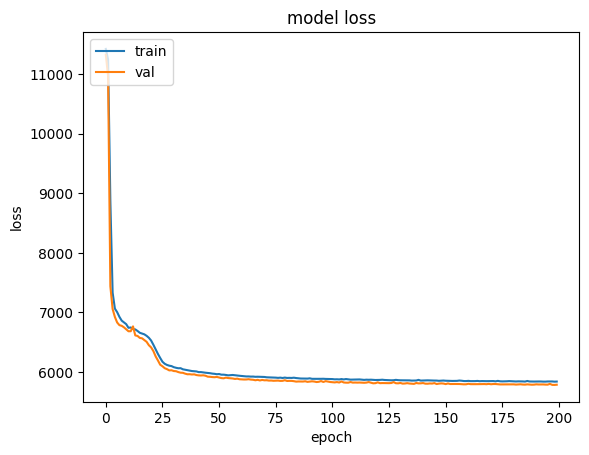

In [13]:
plt.plot(cvae_hist.history['loss'])
plt.plot(cvae_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

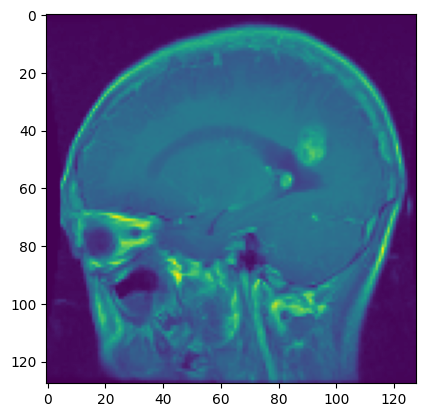

In [14]:
plt.imshow(imgs_train[0])

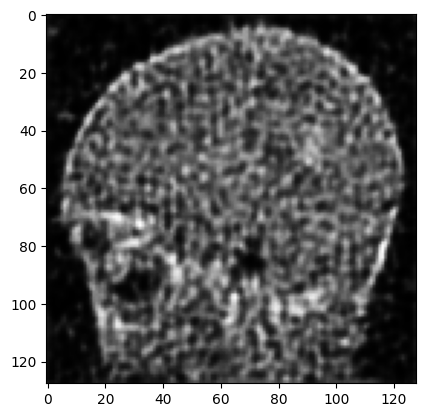

In [52]:
plt.imshow(CVAE.predict([imgs_train2[0:1]+np.random.uniform(-0.8,0.8, size=(1,128,128,1))[0,:,:,:], labels_train[0:1]]).reshape(128,128), cmap=plt.cm.gray)

In [23]:
example = np.random.normal(size=(1, 128,128,1))

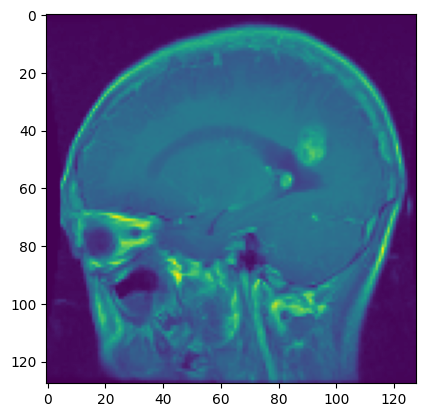

In [53]:
plt.imshow(imgs_train[0])

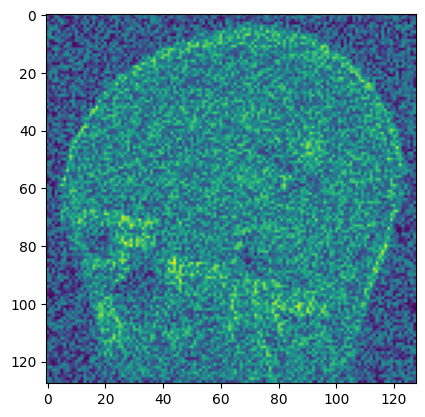

In [47]:
plt.imshow((imgs_train2[0:1]+np.random.uniform(-0.8,0.8, size=(1,128,128,1)))[0,:,:,0])

In [36]:
np.random.uniform(-0.2,0.2, size=(1,128,128,1))

array([[[[ 0.148371  ],
         [-0.0749233 ],
         [-0.16936035],
         ...,
         [ 0.19046278],
         [-0.19241445],
         [-0.02367127]],

        [[ 0.19385593],
         [ 0.03343007],
         [ 0.17418075],
         ...,
         [-0.14822141],
         [-0.09863319],
         [ 0.19756131]],

        [[ 0.0544862 ],
         [-0.12938803],
         [-0.11974441],
         ...,
         [ 0.11712397],
         [-0.04871288],
         [ 0.14406435]],

        ...,

        [[-0.02206484],
         [-0.03609664],
         [-0.18150271],
         ...,
         [ 0.00204503],
         [-0.18480593],
         [-0.10468253]],

        [[ 0.10841573],
         [ 0.03630336],
         [ 0.02889309],
         ...,
         [-0.01313377],
         [ 0.12366699],
         [ 0.10969878]],

        [[-0.16089297],
         [-0.19616527],
         [ 0.07285726],
         ...,
         [ 0.12006915],
         [ 0.08083346],
         [-0.09946372]]]])